In [307]:
%pip install tqdm matplotlib scikit-learn seaborn imutils opencv-python
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

# Introduction
For this project I wanted to use an anime face dataset for the all the tasks in this HW.
This dataset would need to contain high-quality crops of anime character faces and be tagged with a label to do classification on.
However, I wasn't able to find a large enough tagged dataset to sufficiently train a GAN on.
Thus, I am going to use two different datasets for the classification and generation problems.

## CNN Classification: moeimouto-faces
https://www.kaggle.com/datasets/mylesoneill/tagged-anime-illustrations/

I am using the moeimouto-faces subset of this Kaggle dataset.
This dataset contains 14.5k images of cropped anime faces and is labeled by character name.
Here are some examples:

![](imgs/moeimouto-face_examples/face_141_423_129.png)
![](imgs/moeimouto-face_examples/face_411_205_3.png)
![](imgs/moeimouto-face_examples/face_54_327_25.png)
![](imgs/moeimouto-face_examples/face_986_208_103.png)
![](imgs/moeimouto-face_examples/face_98_196_139.png)

This is the following directory structure:
```
moeimouto-faces/
├── XXX_hatsune_miku/
│   ├── face_XXX_XXX_XXX.png
│   └── ...
├── XXX_another_character/
│   ├── face_XXX_XXX_XXX.png
│   └── ...
└── ...
```

An issue that this dataset has is that some of the images may contain NSFW content because the crops were not perfect.
I will set seeds when displaying example images so that no NSFW images are shown when doing data exploration and showing testing results.

## VAE & GAN: Danbooru2019 Portraits [1]
https://gwern.net/crop#danbooru2019-portraits

This dataset is curated by Gwern Branwen, who curates anime datasets and trains models on them. Here is his description of this dataset:
> Danbooru2019 Portraits is a dataset of n = 302,652 (16GB) 512px anime faces.
> The faces were cropped from solo SFW Danbooru2019 images in a relatively broad ‘portrait’ style encompassing
> necklines/ears/hats/etc rather than tightly focused on the face, upscaled to 512px as necessary, and low-quality images deleted by
> manual review using ‘Discriminator ranking’.

I wanted to use this dataset also for the classification task however, he does not provide any labels for this dataset.
I was thinking I would be able to obtain the metadata by querying the Danbooru API since the names of the images are their ID.
However, Gwern states that the IDs in the dataset do not seem to match the metadata on Danbooru and obtaining them without human tagging would be impossible.

Here are some examples of images good to medium quality examples where the face takes up most of the image:

<img src="imgs/Danbooru2019_Portraits_examples/33550030.jpg" height="175" width="175"/>
<img src="imgs/Danbooru2019_Portraits_examples/33541060.jpg" height="175" width="175"/>
<img src="imgs/Danbooru2019_Portraits_examples/33570900.jpg" height="175" width="175"/>
<img src="imgs/Danbooru2019_Portraits_examples/33591820.jpg" height="175" width="175"/>
<img src="imgs/Danbooru2019_Portraits_examples/8-ykzfd1i.jpg" height="175" width="175"/>

Here are some examples of bad quality images that I found:

<img src="imgs/Danbooru2019_Portraits_examples/317118025.jpg" height="175" width="175"/>
<img src="imgs/Danbooru2019_Portraits_examples/33586771.jpg" height="175" width="175"/>
<img src="imgs/Danbooru2019_Portraits_examples/33587020.jpg" height="175" width="175"/>

We can see there may be some issues with this dataset:
- There may be more than one character in it.
- Some of the images have large portions that are just black pixels.
- The image may contain other stuff other than the face (e.g. cropped manga panels).
- The character may only take up a small portion of the picture.

# Task 1: CNN Classification with moeimouto-faces
## Part 1: Dataset preparation

This dataset contains images that are different sizes and some images have alpha channels.
We must do some data preprocessing before we can train a CNN.

In [72]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from common import *
from sklearn.metrics import accuracy_score, recall_score, precision_score
import cv2
from imutils import paths
from sklearn.model_selection import train_test_split
import torchvision

# -=-=-= DataLoader Parameters =-=-=-
# Root directory for dataset
dataroot = "~/Documents/ML_Data/moeimouto-faces/"
# Image size
image_size = 64
# Seed to use for displaying the same images
data_seed = 42
# Number of workers for dataloader
dataloader_workers = 2
# Batch size during training
batch_size = 128

TorchVision has a nice library to easily apply transformations to images while loading the data into a dataset.

To load the images, we apply the following transformation:
- Resize
- Center Crop
- Normalize the data to be [-1, 1]

(see "common.load_data" for implementation)

Using device:  cuda:0


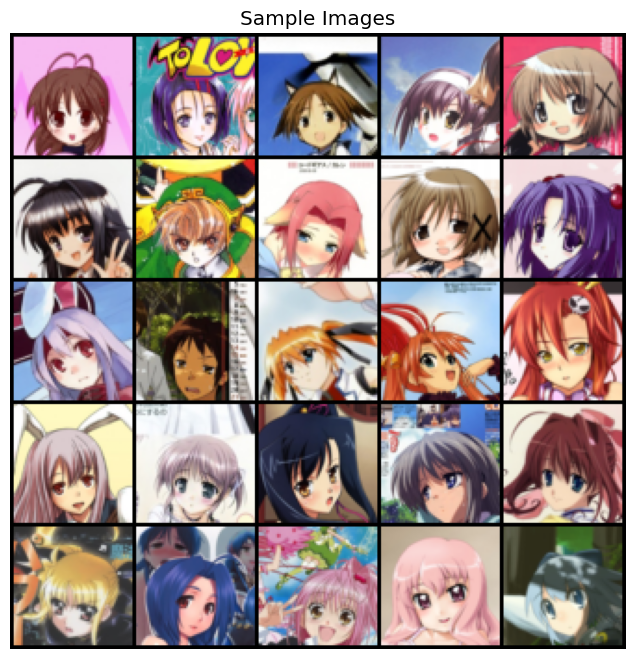

In [73]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Set the seed for the data
seed_everything(data_seed)

# Create a dataloader for sample images
dataset = load_data(dataroot, image_size=image_size, augment=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=dataloader_workers)

# Plot some sample images
images, _, _ = get_sample_images(dataloader, 25)
plot_grid(images, title="Sample Images")

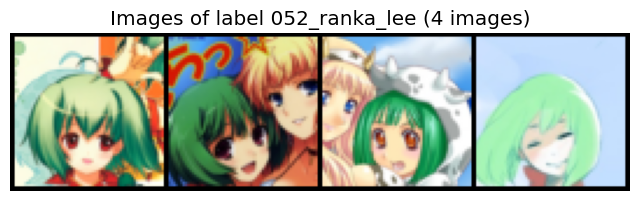

In [74]:
# Example of one class in the batch
images, targets, target = get_sample_images(dataloader, batch_size)
target_with_most_images = max(set(targets), key=list(targets).count)
label_with_most_images = dataloader.dataset.classes[target_with_most_images]
images = images[targets == target_with_most_images]
plot_grid(images, title=f"Images of label {label_with_most_images} ({len(images)} images)", nrow=len(images))

In [75]:
def train_val_test_split(dataset, val_size=0.2, test_size=0.2):
    # TODO maybe add stratification?
    size_val_data = int(val_size * len(dataset))
    size_test_data = int(test_size * len(dataset))

    idxes = np.array(range(len(dataset)))
    np.random.shuffle(idxes)
    train_idxes = idxes[:-size_val_data-size_test_data]
    val_idxes = idxes[-size_val_data-size_test_data:-size_test_data]
    test_idxes = idxes[-size_test_data:]

    train_dataset = torch.utils.data.Subset(dataset, train_idxes)
    val_dataset = torch.utils.data.Subset(dataset, val_idxes)
    test_dataset = torch.utils.data.Subset(dataset, test_idxes)
    train_dataset.classes = dataset.classes
    val_dataset.classes = dataset.classes
    test_dataset.classes = dataset.classes
    train_dataset.targets = np.array(dataset.targets)[train_idxes].tolist()
    val_dataset.targets = np.array(dataset.targets)[val_idxes].tolist()
    test_dataset.targets = np.array(dataset.targets)[test_idxes].tolist()

    return train_dataset, val_dataset, test_dataset

def create_split_loaders(dataset):
    train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=dataloader_workers)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=dataloader_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=dataloader_workers)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    return train_dataloader, val_dataloader, test_dataloader

train_dataloader, val_dataloader, test_dataloader = create_split_loaders(dataset)

Train dataset size: 8639
Validation dataset size: 2879
Test dataset size: 2879


### Basic CNN Model
I created a simple CNN with two Conv. layers with max pooling between them and a FC layer to predict the output labels.

I chose this pattern to see the accuracy with a simple CNN architecture because I'm choosing to test VGG16 later, which is a much deeper CNN with mutiple Conv. layers.

In [76]:

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        size_layer = (image_size - 3) + 1

        self.pooling = nn.MaxPool2d(2, 2)
        size_layer = size_layer // 2

        self.conv2 = nn.Conv2d(8, 16, 3)
        size_layer = (size_layer- 3) + 1

        self.pooling = nn.MaxPool2d(2, 2)
        size_layer = size_layer // 2

        self.fc1 = nn.Linear(16*size_layer**2, 128)
        self.fc2 = nn.Linear(128, len(dataset.classes))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pooling(x)
        x = F.relu(self.conv2(x))
        x = self.pooling(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cnn = CNN().to(device)
total_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {total_params}")

Number of trainable parameters: 425245


In [77]:
def train(net, max_epochs, dataloader, lr=0.001, val_dataloader=None, model_path:str="cnn.pth"):
    losses = []
    avg_val_losses = []
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    epochs = tqdm(range(max_epochs))
    for epoch in epochs:
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            losses.append(loss.item())
            if i % 10 == 9:
                epochs.set_description(f"Loss: {running_loss/10:.3f}")
                running_loss = 0.0
        
        if val_dataloader is not None:
            with torch.no_grad():
                val_loss = 0.0
                for i, data in enumerate(val_dataloader, 0):
                    inputs, labels = data[0].to(device), data[1].to(device)
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                val_loss /= len(val_dataloader)
                if len(avg_val_losses) == 0 or val_loss < min(avg_val_losses):
                    torch.save(net.state_dict(), model_path)
                avg_val_losses.append(val_loss)
                epochs.set_postfix(val_loss=f"{val_loss:.3f}")
            
    plt.title("Average Training Loss per Epoch")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    size_per_batch = int(np.ceil(len(dataloader.dataset) / dataloader.batch_size))
    plt.plot(np.mean(np.array(losses).reshape(-1, size_per_batch), axis=1))
    plt.show()

    if val_dataloader is not None:
        plt.title("Average Validation Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.plot(avg_val_losses, c="red")
        plt.show()
        print(f"Best model at {np.argmin(avg_val_losses)+1} with minimum validation loss: {min(avg_val_losses):.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Loss: 0.328: 100%|██████████| 20/20 [01:29<00:00,  4.50s/it, val_loss=3.212]


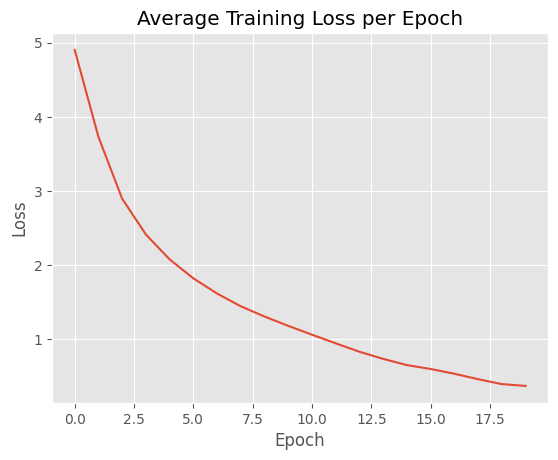

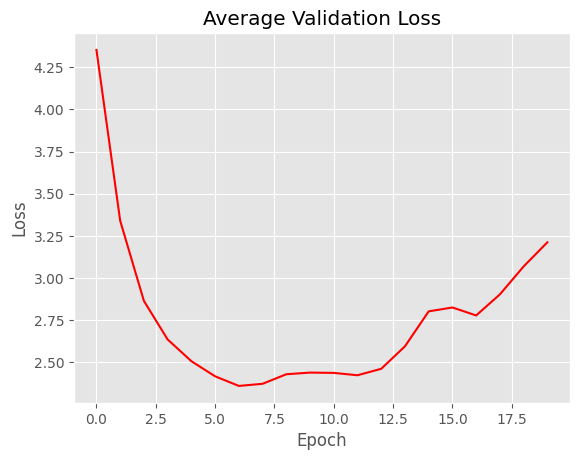

Best model at 7 with minimum validation loss: 2.360


In [78]:
cnn = CNN().to(device)
train(cnn, 20, train_dataloader, val_dataloader=val_dataloader)

In [79]:

def load_model(model_path:str):
    net = CNN().to(device)
    net.load_state_dict(torch.load(model_path))
    net.eval()
    return net

def test(net, dataloader):
    net.eval()
    predicted_targets = []
    true_targets = []
    with torch.no_grad():
        for data in dataloader:
            images, target = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_targets.extend(predicted.cpu().numpy())
            true_targets.extend(target.cpu().numpy())
    
    predicted_targets = np.array(predicted_targets)
    true_targets = np.array(true_targets)

    accuracy = accuracy_score(true_targets, predicted_targets)

    print(f"Metrics for {len(dataloader.dataset)} test images:")
    print(f"Accuracy: {100*accuracy:.2f}%")

cnn = load_model("cnn.pth")
test(cnn, test_dataloader)

Metrics for 2879 test images:
Accuracy: 42.51%


## Part 2: Testing with VGG16

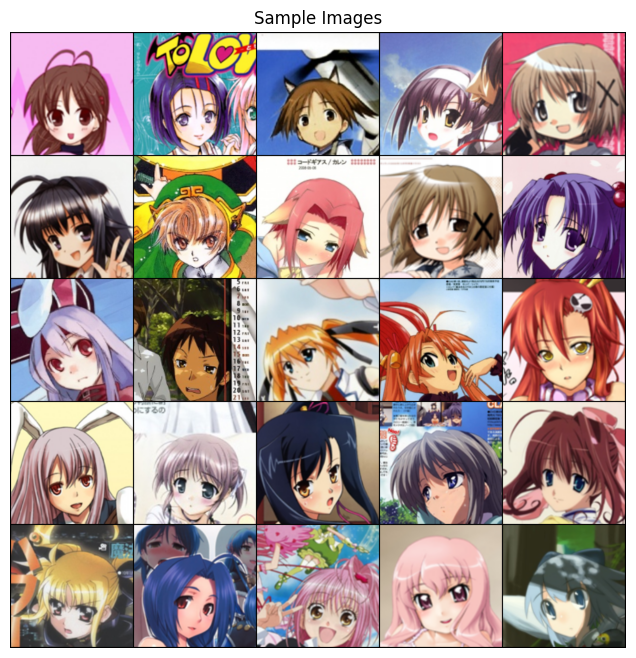

Train dataset size: 8639
Validation dataset size: 2879
Test dataset size: 2879


In [ ]:
# Resizing to 224x224 because conv layers were designed for that size
image_size = 224
seed_everything(data_seed)

# Create the dataloader
dataset = load_data(dataroot, image_size=image_size, augment=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=dataloader_workers)

# Plot some sample images
images, _, _ = get_sample_images(dataloader, 25)
plot_grid(images, title="Sample Images")

# Create the train val test split dataloaders
train_dataloader, val_dataloader, test_dataloader = create_split_loaders(dataset)

In [ ]:
def init_vgg16(weights="IMAGENET1K_V1"):
    # Loading VGG16
    vgg16 = torchvision.models.vgg16(weights=weights).to(device)

    # Changing the last layer to match the number of classes in our dataset
    last_layer_features = vgg16.classifier[6].in_features
    vgg16.classifier[6] = nn.Linear(last_layer_features, len(dataset.classes)).to(device)

    # Freezing Conv Layers
    for param in vgg16.features.parameters():
        param.requires_grad = False
    
    return vgg16

Loss: 0.667: 100%|██████████| 10/10 [02:06<00:00, 12.66s/it, val_loss=3.418]


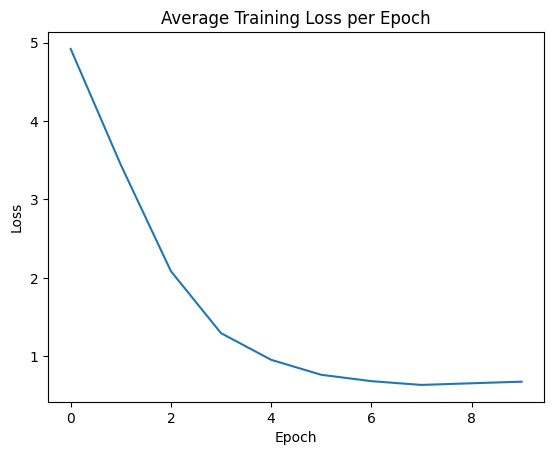

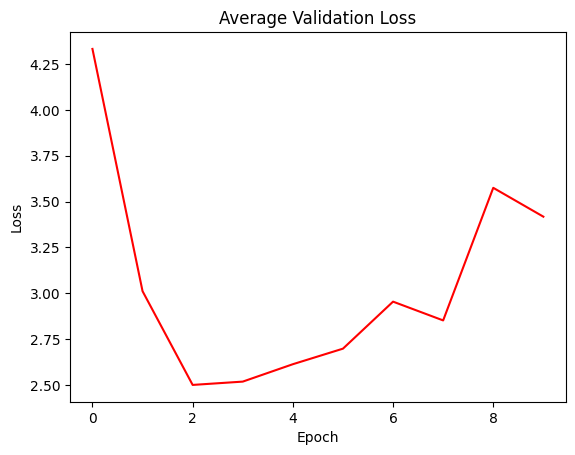

Best model at 3 with minimum validation loss: 2.500


In [ ]:
vgg16 = init_vgg16()
train(vgg16, 10, train_dataloader, val_dataloader=val_dataloader, model_path="vgg16.pth")

In [ ]:
vgg16 = init_vgg16(weights=None)
vgg16.load_state_dict(torch.load("vgg16.pth"))
test(vgg16, test_dataloader)

Metrics for 2879 test images:
Accuracy: 59.57%


We can see that VGG16 was able to perform better than my simple CNN.
- A possible reason for this is due to the fact that
  there are more conv. layers so it can fit the
  complex task better.
- The images were resized to 224x224 meaning there were more features
  that the model could learn from.
  

## Part 3: Testing with Data Augmentation

The transforms that are applied for the data augmentation are:
- Random Horizontal Flip with prob=0.1
- Random 10 degree Rotation
- ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
- GaussianBlur(kernel_size=3)

These are small changes to help increase the model's generalization performance.

Augmenting dataset
Train dataset size: 17278
Validation dataset size: 5758
Test dataset size: 5758


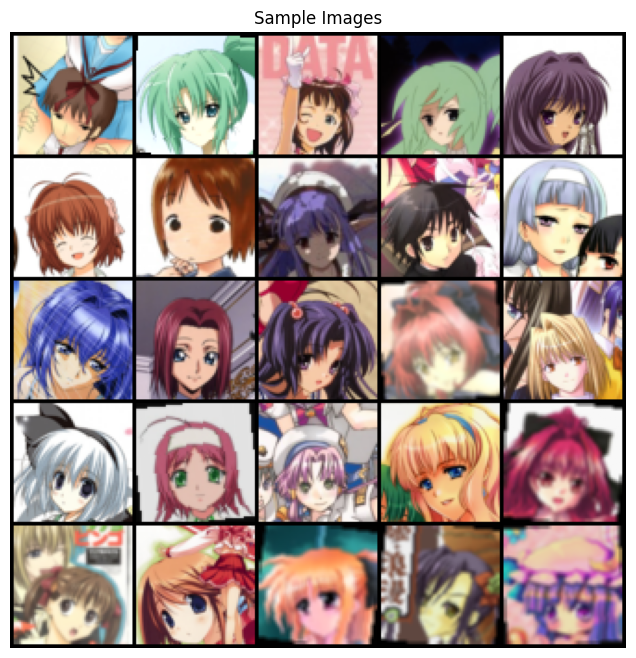

In [ ]:
# Resizing back to 64x64
image_size = 64
seed_everything(data_seed+1)

# Create the dataloaders
dataset = load_data(dataroot, image_size=image_size, augment=True)
train_dataloader, val_dataloader, test_dataloader = create_split_loaders(dataset)

# Plot some sample images
images, _, _ = get_sample_images(train_dataloader, 25)
plot_grid(images, title="Sample Images")

Loss: 0.276: 100%|██████████| 50/50 [10:12<00:00, 12.25s/it, val_loss=1.555]


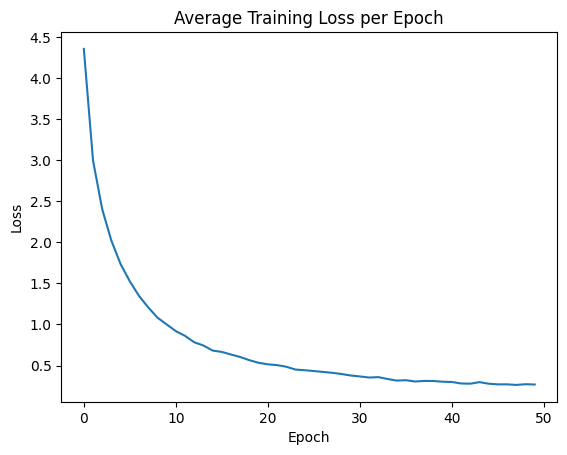

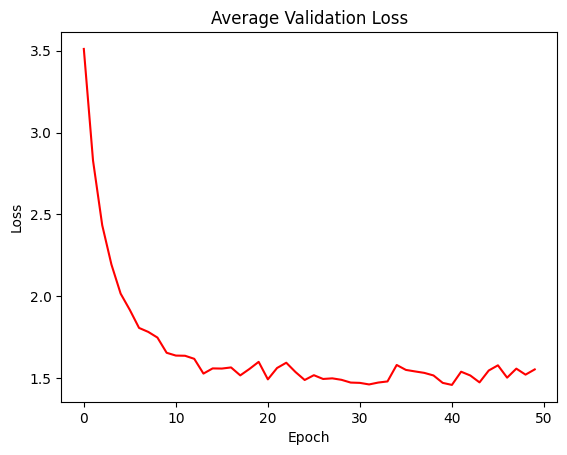

Best model at 41 with minimum validation loss: 1.460


In [ ]:
cnn = CNN().to(device)
train(cnn, 50, train_dataloader, val_dataloader=val_dataloader, model_path="cnn_augmented.pth")

In [ ]:
cnn = load_model("cnn_augmented.pth")
test(cnn, test_dataloader)

Metrics for 5758 test images:
Accuracy: 71.36%


We can also see in the validation loss graph that the loss does not rise meaning that the model has
more generalization capability and thus overfits less and its accuracy increased.

## VAE
See vae.ipynb

## GAN
See dcgan.ipynb

I separated the VAE and GAN into their own nb so I could run them in the background since they take a while to train.

# Graduate Task
One of the first models for image segmentation was a Fully Convolution Network (FCN) [2] which has inspired more modern architectures like UNets [3] where the conv. layers contract and expand along with skip connections across the "U" for better localization. More state of the art models like SegFormer [4] are now incorporating transformers in their architecture.

Some of the metrics used in image segmenation tasks are MIoU and Dice. MIoU stands for Mean Intersection over Union and for each class, it measures the overlap between the predicted segmentation and the ground truth and divde that by the area of the union between them. Each classes IoU is now averaged together to obtain the final score. Given the ground truth, $Y$ and the predicted segmentation $\hat{Y}$, IoU can be calculated by:
$$
IoU = \frac{\hat{Y} \cap Y}{\hat{Y} \cup Y}
$$
If we use TP, FP, FN to represent True Positive pixels, False Positive pixels, and False Negative pixels, we can rewrite the formula as:
$$
IoU = \frac{TP}{TP+FP+FN}
$$
And thus the mean over all the classes is:
$$
MIoU = \frac{1}{C}\sum_{c=1}^C IoU_c
$$


Dice is commonly used as a loss function and similar to the IoU metric before, Dice also measure the overlap between twice the area of overlap divided by the total number of pixels:
$$
Dice = \frac{2TP}{TP + FP + FN}
$$
This makes the metric more sensitive because more of an emphasis is placed on TP pixels.


This implementation was from pyimagesearch: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [60]:
# -=-=-= DataLoader Parameters =-=-=-
# Root directory for dataset
dataroot = "/home/tyler/Documents/ML_Data/CVC-ClinicDB/"
# base path of the dataset
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(dataroot, "Original")
MASK_DATASET_PATH = os.path.join(dataroot, "Truth")
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [70]:
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.0005
NUM_EPOCHS = 150
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.4
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [62]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

In [63]:
class Block(nn.Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = nn.Conv2d(inChannels, outChannels, 3)
		self.relu = nn.ReLU()
		self.conv2 = nn.Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

class Encoder(nn.Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = nn.ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = nn.MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

class Decoder(nn.Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = nn.ModuleList(
			[nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = nn.ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = transforms.CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

class UNet(nn.Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [ ]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
print(imagePaths)
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

# define transformations
transform = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT,
		INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transform)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transform)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = torch.utils.data.DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = torch.utils.data.DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())

In [65]:
# initialize our UNet model
unet = UNet(encChannels=(3,64,128,256), decChannels=(256,128,64)).to(DEVICE)
# initialize loss function and optimizer
lossFunc = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}


In [66]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
epochs = tqdm(range(NUM_EPOCHS))
for e in epochs:
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	epochs.set_description("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss: 0.134412, Test loss: 0.3546: 100%|██████████| 150/150 [05:21<00:00,  2.14s/it]

[INFO] total time taken to train the model: 321.27s


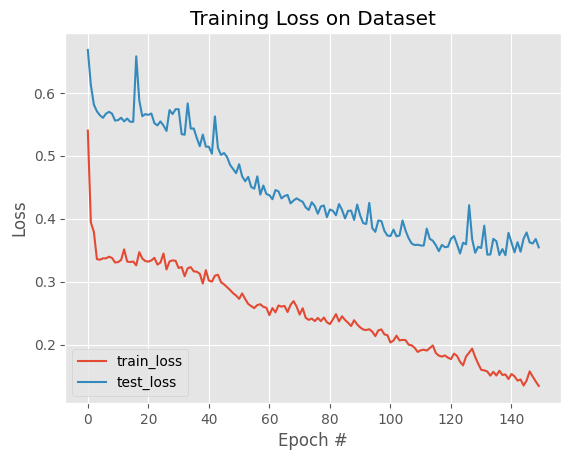

In [67]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

[INFO] loading up test image paths...
[INFO] load up model...


/tmp/ipykernel_4114059/747561396.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


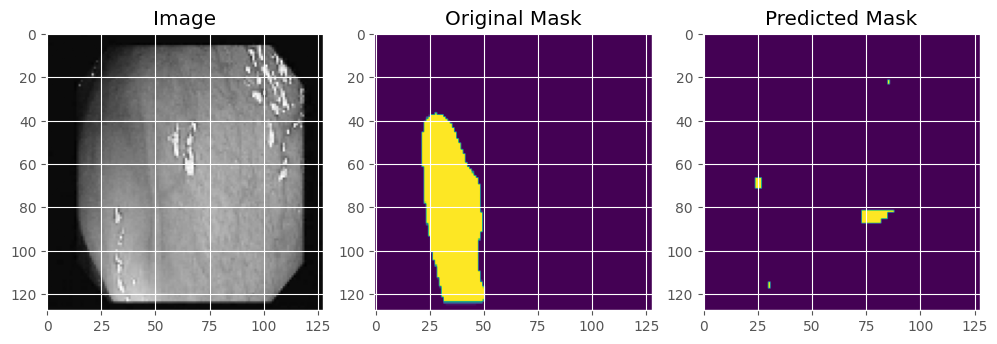

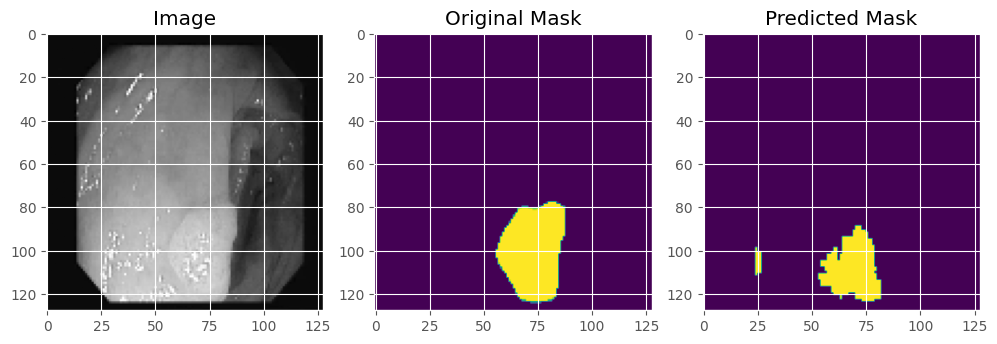

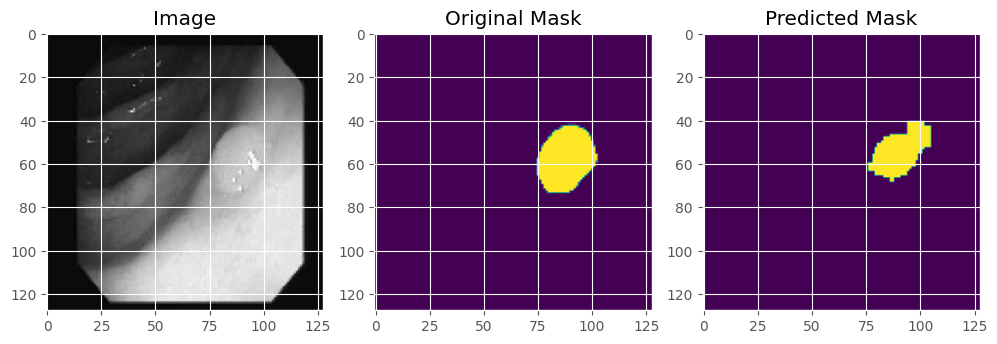

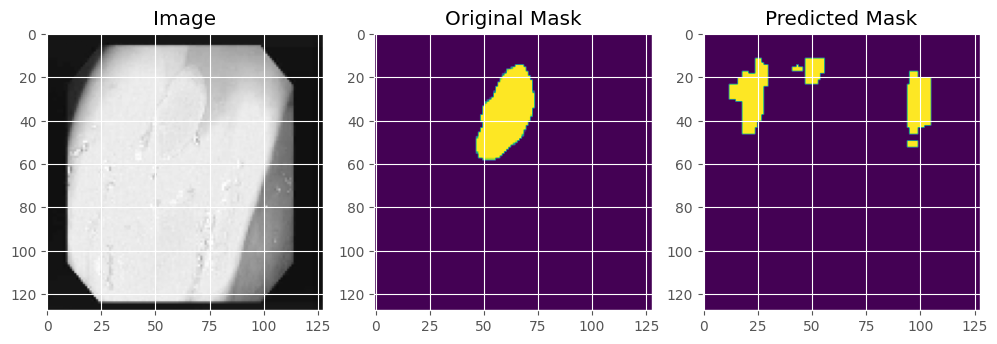

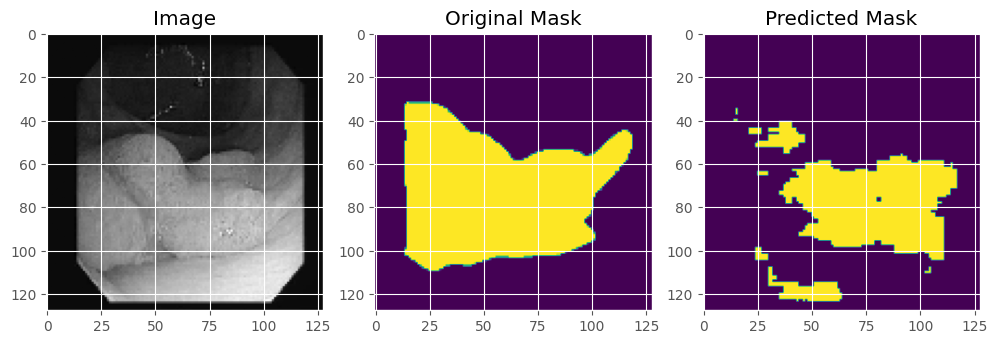

In [71]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
	
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT,
			INPUT_IMAGE_HEIGHT))
		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=5)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)

In [69]:
def mean_dice(pred, target):
    smooth = 1e-15
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def mean_iou(pred, target):
    smooth = 1e-15
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def test_unet():
    dice = []
    iou = []
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the test set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the dice and IOU
            # for the current batch
            pred = unet(x)
            pred = torch.sigmoid(pred)
            pred = (pred > THRESHOLD).float()
            dice.append(mean_dice(pred, y).cpu().numpy())
            iou.append(mean_iou(pred, y).cpu().numpy())

    # calculate the average dice and IOU
    avgDice = np.mean(dice)
    avgIOU = np.mean(iou)
    # print the model training and validation information
    print(f"Average Dice: {avgDice:.4f}, Average IOU: {avgIOU:.4f}")

test_unet()

Average Dice: 0.5729, Average IOU: 0.4015


The UNet on the paperswithcode.com leaderboard has no MIoU but does have Dice. It achieved a dice of 0.8230
but my model achieves a Dice of 0.5729 which is much lower than Dice however, the original UNet implementation
has 5 layers of conv filters with sizes of 64,128,256,512,1024 however, I was only able to fit a model with 3 layers
of conv filters with sizes 64, 128, 256.
Another model that is based on transformers, FCBFormer, achieves a high 0.9469 Dice on the benchmark.
Even in image segmentation, transformers perform exceptionally well.

# References
[1] Gwern Branwen, Anonymous, & The Danbooru Community; “Danbooru2019 Portraits: A Large-Scale Anime Head Illustration
Dataset”, 2019-03-12. Web. Accessed [Mar. 1, 2024] https://gwern.net/crop#danbooru2019-portraits

[2] Johnathan Long, et al.; "Fully Convolutional Networks for Semantic Segmentation", 2014-09-14. Web. Acessed [Mar. 13, 2024] https://arxiv.org/abs/1411.4038

[3] Olaf Ronneberger, et al.; "U-Net: Convolutional Networks for Biomedical Image Segmentation", 2015-05-18.
Web. Acessed [Mar. 13, 2024] https://arxiv.org/abs/1505.04597

[4] Enze Xie, et al.; "SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers", 2021-05-31. Web. Acessed [Mar. 13, 2024] https://arxiv.org/abs/2105.15203